## Daily Challenge: W3_D3

Work with the “Airplane Crashes and Fatalities upto 2023” dataset, which provides comprehensive details about airplane crashes, including dates, locations, fatalities, and more.

#### Step 1: Data Import and Cleaning:

In [30]:
# Data manipulation
import pandas as pd
import numpy as np

# Statistical analysis
from scipy import stats
from itertools import combinations  # For comparing multiple groups

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [31]:
df = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv", encoding='latin1')

In [32]:
# Preview the first few rows of the dataset
df.head()

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


In [33]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   4998 non-null   object 
 1   Time                   3486 non-null   object 
 2   Location               4994 non-null   object 
 3   Operator               4988 non-null   object 
 4   Flight #               1329 non-null   object 
 5   Route                  4221 non-null   object 
 6   AC Type                4983 non-null   object 
 7   Registration           4724 non-null   object 
 8   cn/ln                  4330 non-null   object 
 9   Aboard                 4980 non-null   float64
 10  Aboard Passangers      4769 non-null   float64
 11  Aboard Crew            4772 non-null   float64
 12  Fatalities             4990 non-null   float64
 13  Fatalities Passangers  4756 non-null   float64
 14  Fatalities Crew        4757 non-null   float64
 15  Grou

In [34]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract useful time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [35]:
# Check missing values in each column
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_values)

Missing values per column:
 Flight #                 3669
Time                     1512
Route                     777
cn/ln                     668
Registration              274
Fatalities Passangers     242
Fatalities Crew           241
Aboard Passangers         229
Aboard Crew               226
Summary                    64
Ground                     42
Aboard                     18
AC Type                    15
Operator                   10
Fatalities                  8
Location                    4
Date                        0
Year                        0
Month                       0
Day                         0
dtype: int64


In [36]:
# Check current column names
print("Column names:\n", df.columns.tolist())

# Try to find and drop the column related to 'Flight #'
flight_cols = [col for col in df.columns if 'flight' in col.lower()]
if flight_cols:
    df = df.drop(columns=flight_cols)
    print(f"Dropped column: {flight_cols[0]}")
else:
    print("No flight-related column found to drop.")

# Create a unique flight identifier using available fields
df['flight_id'] = (
    df['Date'].astype(str) + ' | ' +
    df['Time'].fillna('Unknown') + ' | ' +
    df['Operator'].fillna('Unknown') + ' | ' +
    df['Location'].fillna('Unknown')
)

# Preview the new flight_id column
print(df[['flight_id']].head())

Column names:
 ['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'AC Type', 'Registration', 'cn/ln', 'Aboard', 'Aboard Passangers', 'Aboard Crew', 'Fatalities', 'Fatalities Passangers', 'Fatalities Crew', 'Ground', 'Summary', 'Year', 'Month', 'Day']
Dropped column: Flight #
                                           flight_id
0  1908-09-17 | 17:18 | Military - U.S. Army | Fo...
1  1909-09-07 | Unknown | Unknown | Juvisy-sur-Or...
2  1912-07-12 | 6:30 | Military - U.S. Navy | Atl...
3  1913-08-06 | Unknown | Private | Victoria, Bri...
4  1913-09-09 | 18:30 | Military - German Navy | ...


In [37]:
# Drop rows where Date or Fatalities are missing (required for time-based and survival analysis)
df = df.dropna(subset=['Date', 'Fatalities'])

# Convert key numeric columns to integers, coercing invalid entries and filling remaining NaNs with 0
columns_to_convert = ['Aboard', 'Fatalities', 'Ground']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Optional: fill secondary passenger/crew columns with 0 (if not already done)
cols_to_fill = ['Aboard Passangers', 'Aboard Crew', 'Fatalities Passangers', 'Fatalities Crew']
df[cols_to_fill] = df[cols_to_fill].fillna(0).astype(int)

In [38]:
# Final check on data types and summary
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 0 to 4997
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   4990 non-null   datetime64[ns]
 1   Time                   3486 non-null   object        
 2   Location               4986 non-null   object        
 3   Operator               4980 non-null   object        
 4   Route                  4220 non-null   object        
 5   AC Type                4977 non-null   object        
 6   Registration           4719 non-null   object        
 7   cn/ln                  4330 non-null   object        
 8   Aboard                 4990 non-null   int64         
 9   Aboard Passangers      4990 non-null   int64         
 10  Aboard Crew            4990 non-null   int64         
 11  Fatalities             4990 non-null   int64         
 12  Fatalities Passangers  4990 non-null   int64         
 13  Fataliti

In [39]:
print(df.describe())

                                Date       Aboard  Aboard Passangers  \
count                           4990  4990.000000        4990.000000   
mean   1971-07-22 18:42:51.222444904    31.133467          25.812826   
min              1908-09-17 00:00:00     0.000000           0.000000   
25%              1951-07-12 00:00:00     7.000000           2.000000   
50%              1970-12-06 00:00:00    16.000000          11.000000   
75%              1992-06-22 00:00:00    35.000000          29.000000   
max              2023-11-01 00:00:00   644.000000         614.000000   
std                              NaN    45.510523          43.480131   

       Aboard Crew   Fatalities  Fatalities Passangers  Fatalities Crew  \
count  4990.000000  4990.000000            4990.000000      4990.000000   
mean      4.283567    22.373547              18.160321         3.411423   
min       0.000000     0.000000               0.000000         0.000000   
25%       2.000000     4.000000               0.000

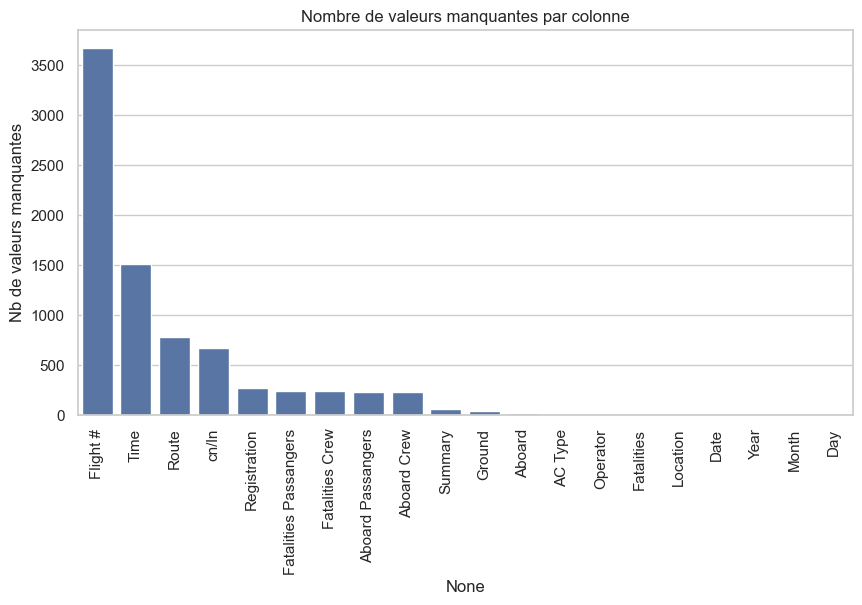

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.title("Nombre de valeurs manquantes par colonne")
plt.ylabel("Nb de valeurs manquantes")
plt.show()

In [41]:
# Convert all numeric columns and fill missing values
cols_numeric = ['Aboard', 'Aboard Passangers', 'Aboard Crew',
                'Fatalities', 'Fatalities Passangers', 'Fatalities Crew', 'Ground']

for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Create survival-related columns
df['Survivors'] = df['Aboard'] - df['Fatalities']
df['Survival Rate'] = df['Survivors'] / df['Aboard']
df['Survival Rate'] = df['Survival Rate'].replace([np.inf, -np.inf], 0).fillna(0)

# Clean column names for consistency
df.columns = df.columns.str.replace(" ", "_").str.replace("#", "Number").str.replace("/", "_").str.lower()

# Final check
print(df.shape)
print(df.columns.tolist())

(4990, 22)
['date', 'time', 'location', 'operator', 'route', 'ac_type', 'registration', 'cn_ln', 'aboard', 'aboard_passangers', 'aboard_crew', 'fatalities', 'fatalities_passangers', 'fatalities_crew', 'ground', 'summary', 'year', 'month', 'day', 'flight_id', 'survivors', 'survival_rate']


### 🔍 Interpretation of the Missing Values Chart

This chart displays the number of missing values for each column in the dataset. Below is a summary of the key findings and the data cleaning decisions taken:

#### 🧠 Observations:
- **`Flight #`** contains more than 70% missing values. Most entries—especially military or early aviation incidents—lack this information.
- **`Time`** is missing in ~30% of the records, likely due to reporting limitations or historical data gaps.
- Moderate missing values are found in **`Route`**, **`cn/ln`**, and **`Registration`**, which are less consistently reported.
- Critical fields like **`Date`**, **`Fatalities`**, **`Aboard`**, and **`Operator`** are nearly complete, allowing for reliable analysis.

#### 🛠️ Data Cleaning Actions:
- **Dropped `Flight #`**: Due to high missingness and limited analytical value.
- **Created `flight_id`**: A custom identifier combining `Date`, `Time`, `Operator`, and `Location`, with missing values replaced by `'Unknown'`.
- **Converted numeric columns**: All numeric fields (`Aboard`, `Fatalities`, `Ground`, etc.) were cleaned, converted to integers, and missing values filled with `0`.
- **Derived features added**:
  - `survivors` = `aboard` - `fatalities`
  - `survival_rate` = `survivors` / `aboard`

#### ✅ Purpose of These Changes:
- Ensure a clean and analyzable dataset.
- Prevent misleading results due to missing or inconsistent data.
- Enable accurate statistical analysis and visual storytelling.

#### Step 2: Exploratory Data Analysis

Total number of crashes: 4990
Total number of fatalities: 111644
Average survival rate across all crashes: 18.09 %


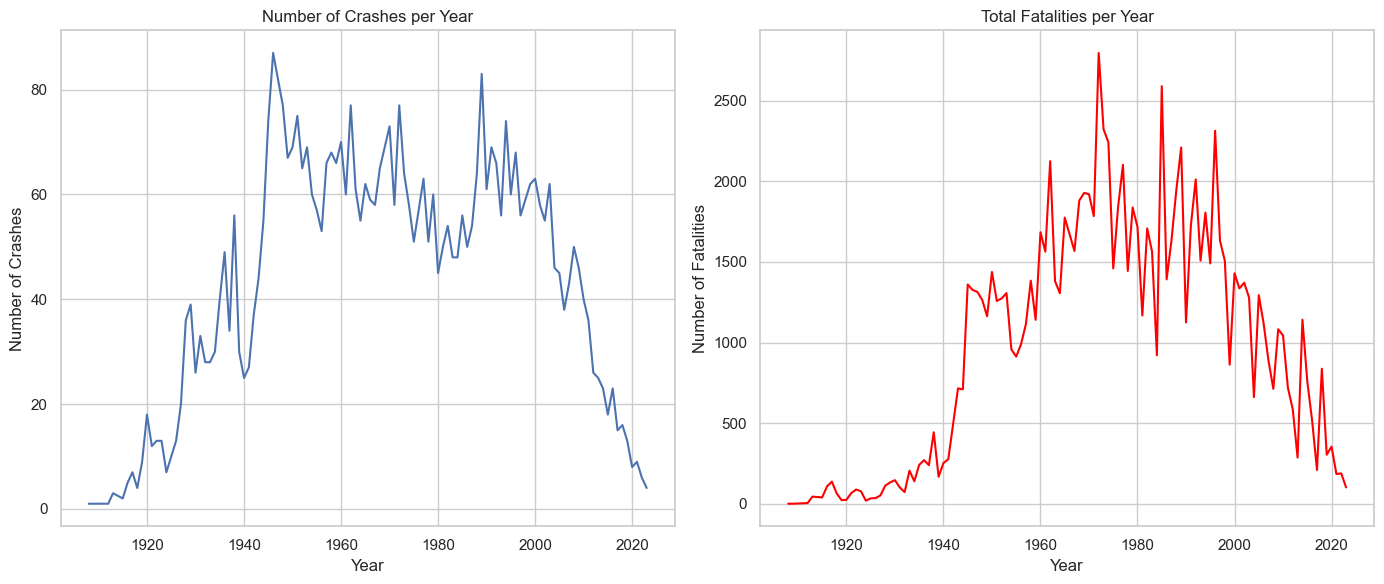

In [42]:
# 1. Global statistics
total_crashes = len(df)
total_fatalities = df['fatalities'].sum()
average_survival_rate = df['survival_rate'].mean()

print("Total number of crashes:", total_crashes)
print("Total number of fatalities:", total_fatalities)
print("Average survival rate across all crashes:", round(average_survival_rate * 100, 2), "%")

# 2. Crashes per year
crashes_per_year = df.groupby('year').size()

# 3. Fatalities per year
fatalities_per_year = df.groupby('year')['fatalities'].sum()

# 4. Plotting both trends
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=crashes_per_year.index, y=crashes_per_year.values)
plt.title("Number of Crashes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")

plt.subplot(1, 2, 2)
sns.lineplot(x=fatalities_per_year.index, y=fatalities_per_year.values, color='red')
plt.title("Total Fatalities per Year")
plt.xlabel("Year")
plt.ylabel("Number of Fatalities")

plt.tight_layout()
plt.show()

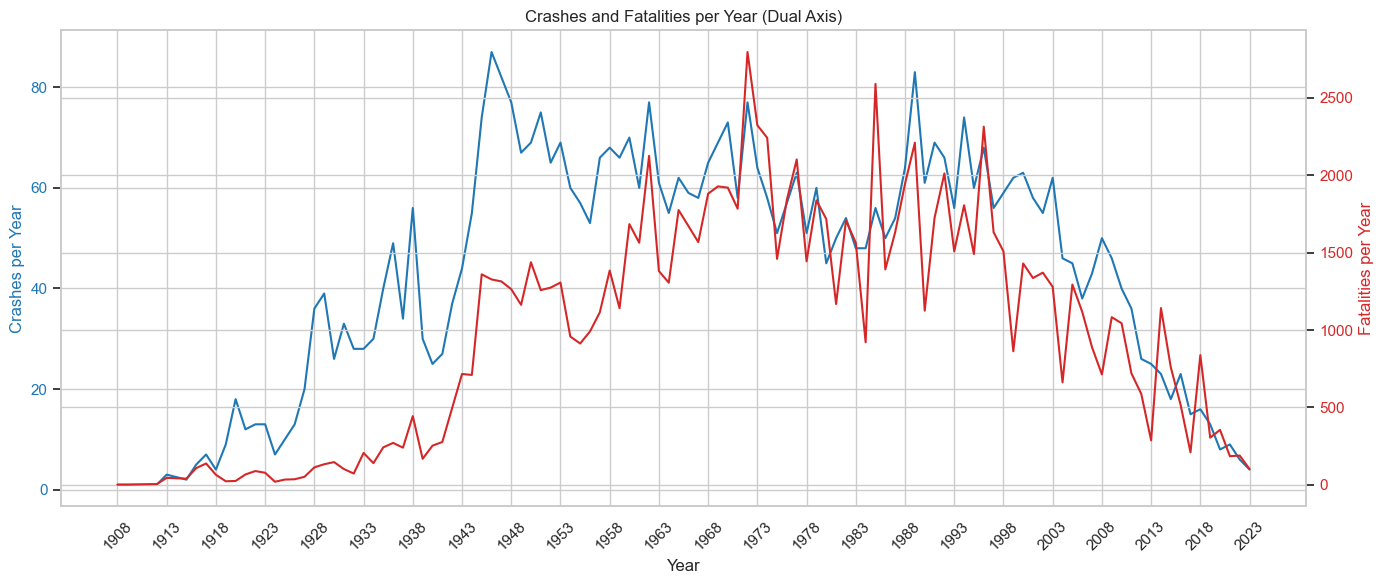

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Aggregated yearly data
crashes_per_year = df.groupby('year').size()
fatalities_per_year = df.groupby('year')['fatalities'].sum()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot crashes (left Y-axis)
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Crashes per Year', color=color)
ax1.plot(crashes_per_year.index, crashes_per_year.values, color=color, label='Crashes')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(np.arange(df['year'].min(), df['year'].max()+1, 5))
ax1.set_xticklabels(np.arange(df['year'].min(), df['year'].max()+1, 5), rotation=45)

# Create a second y-axis (right side)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Fatalities per Year', color=color)
ax2.plot(fatalities_per_year.index, fatalities_per_year.values, color=color, label='Fatalities')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Crashes and Fatalities per Year (Dual Axis)')
fig.tight_layout()
plt.show()


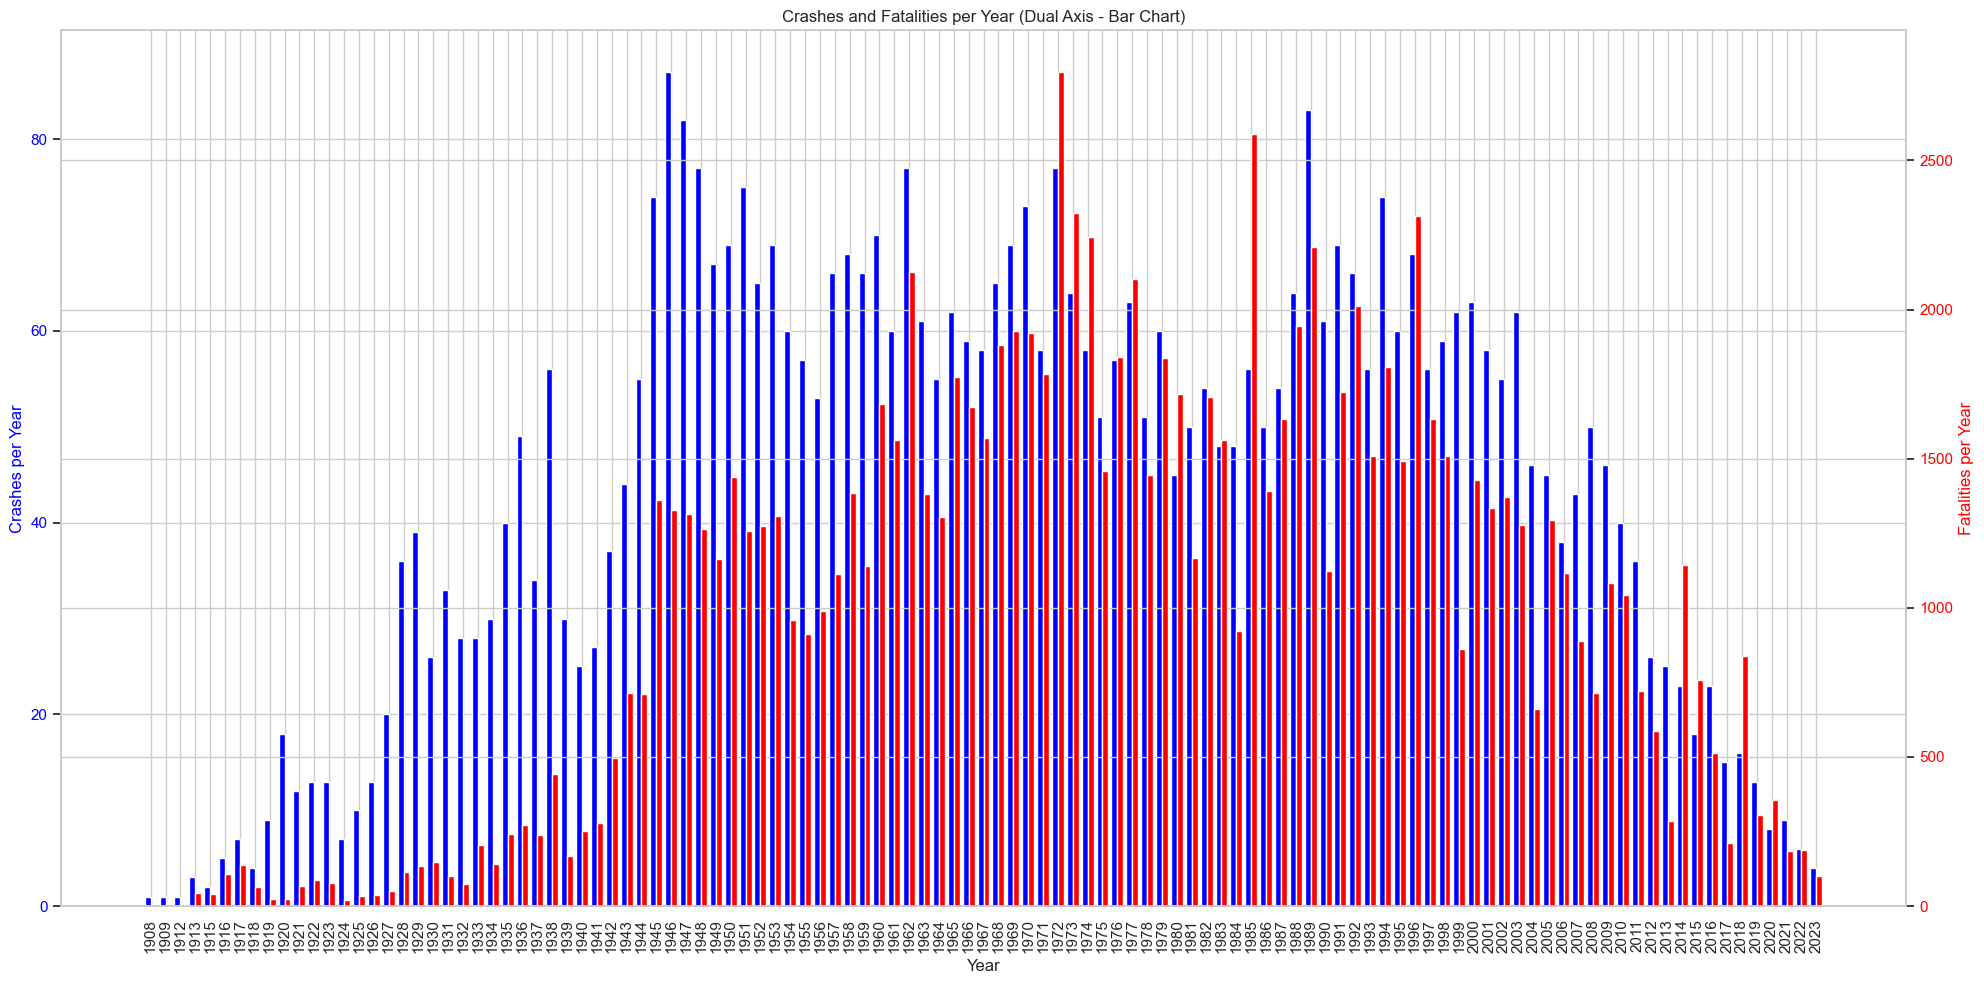

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregated yearly data
crashes_per_year = df.groupby('year').size()
fatalities_per_year = df.groupby('year')['fatalities'].sum()

# Shared x-axis positions
years = crashes_per_year.index
x = np.arange(len(years))
width = 0.4

# Create figure and twin axes
fig, ax1 = plt.subplots(figsize=(20, 10))

# Bar for crashes (left Y-axis)
bar1 = ax1.bar(x - width/2, crashes_per_year.values, width, label='Crashes', color='blue')
ax1.set_ylabel('Crashes per Year', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=90)
ax1.set_xlabel('Year')

# Bar for fatalities (right Y-axis)
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, fatalities_per_year.values, width, label='Fatalities', color='red')
ax2.set_ylabel('Fatalities per Year', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Crashes and Fatalities per Year (Dual Axis - Bar Chart)')
fig.tight_layout()
plt.show()


### Crashes and Fatalities per Year – Dual-Axis Bar Chart

This dual-axis bar chart visualizes two key indicators over time:
- **Blue bars** (left Y-axis): Number of crashes per year
- **Red bars** (right Y-axis): Number of fatalities per year

Over the period from **1908 to 2023**, we analyzed the **annual number of airplane crashes**. The following trends were identified based on the time series data:

#### 1. Early aviation era (1908–1930)
- Very few crashes occurred.
- Aviation was still experimental with limited flight activity.
- Many early incidents were likely unreported or poorly documented.

#### 2. Expansion period (1930–1980)
- A sharp increase in crashes occurred, especially during and after World War II.
- Noticeable **peaks** appear:
  - Around the **1940s**, aligned with **World War II**
  - During the **1960s–1970s**, reflecting intense aviation development
- These peaks should be analyzed further as they may correspond to a high number of **military flights** with low passenger counts.

#### 3. Modern era (1980–2023)
- A clear **decline in crash frequency** began after the 1980s and accelerated post-2000.
- This drop is attributed to advancements in:
  - Aircraft design and technology
  - Safety regulations and enforcement
  - Pilot training and simulation
  - Maintenance protocols

#### Key Insight:
Some peak periods show a **high number of crashes**, but a **low average number of passengers per flight**. This suggests that **many military or low-capacity flights** (e.g., training missions) are included, particularly during wartime. These cases increase crash frequency but do not necessarily reflect high human loss.

#### Conclusion:
The long-term trend shows a significant improvement in aviation safety, with fewer crashes and more advanced preventive systems since the early 2000s.

#### Step 3: Statistical Analysis

##### Descriptive Statistics with SciPy

In [45]:
from scipy import stats

# Basic statistics for fatalities
fatalities = df['fatalities']
print("Fatalities:")
print("Mean:", fatalities.mean())
print("Median:", fatalities.median())
print("Standard Deviation:", fatalities.std())

# Basic statistics for survival rate
survival_rate = df['survival_rate']
print("\nSurvival Rate:")
print("Mean:", survival_rate.mean())
print("Median:", survival_rate.median())
print("Standard Deviation:", survival_rate.std())

Fatalities:
Mean: 22.37354709418838
Median: 11.0
Standard Deviation: 35.06174065974316

Survival Rate:
Mean: 0.18094346125666377
Median: 0.0
Standard Deviation: 0.3114138464627394


##### Visualizing Distributions

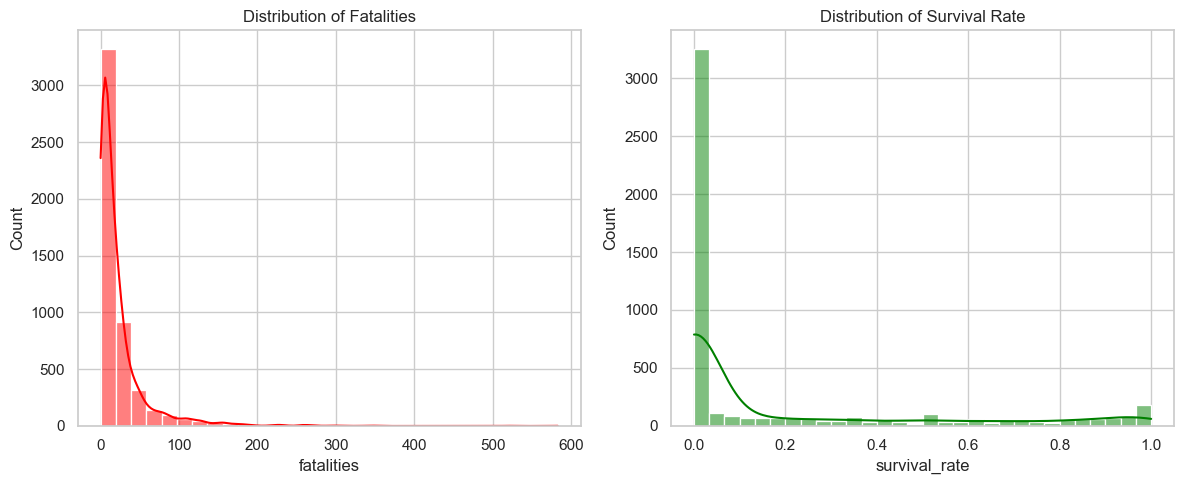

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Distribution of fatalities
plt.subplot(1, 2, 1)
sns.histplot(fatalities, kde=True, color='red', bins=30)
plt.title("Distribution of Fatalities")

# Distribution of survival rate
plt.subplot(1, 2, 2)
sns.histplot(survival_rate, kde=True, color='green', bins=30)
plt.title("Distribution of Survival Rate")

plt.tight_layout()
plt.show()

##### Hypothesis Testing Between Decades

In [47]:
# Add decade column if not done yet
df['decade'] = (df['year'] // 10) * 10

# Compare two decades: 1970s vs. 2000s
group_70s = df[df['decade'] == 1970]['fatalities']
group_2000s = df[df['decade'] == 2000]['fatalities']

# T-test: are average fatalities different?
t_stat, p_value = stats.ttest_ind(group_70s, group_2000s, equal_var=False, nan_policy='omit')
print(f"T-test: 1970s vs. 2000s")
print(f"t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")


T-test: 1970s vs. 2000s
t-statistic = 3.99, p-value = 0.0001


### Statistical Analysis

#### 1. Descriptive Statistics

| Metric              | Fatalities        | Survival Rate     |
|---------------------|-------------------|-------------------|
| Mean                | 22.37             | 0.181             |
| Median              | 11.00             | 0.000             |
| Standard Deviation  | 35.06             | 0.311             |

**Interpretation**:
- Most crashes involved fewer than 25 fatalities, but the high standard deviation suggests the presence of extreme events with many deaths.
- The survival rate is heavily skewed toward 0, meaning that in many crashes, there were no survivors.
- A small portion of crashes had a survival rate close to 1, indicating minor incidents or successful emergency landings.

#### 2. Distributions Observed

- The **distribution of fatalities** is right-skewed: most events had few deaths, but a few outliers had extremely high numbers.
- The **distribution of survival rates** peaks at 0 and drops quickly, with only a small number of crashes showing significant survival rates.

#### 3. Hypothesis Test: 1970s vs. 2000s Fatalities

We performed an independent t-test to compare the **average fatalities per crash** between the 1970s and the 2000s.

- **T-statistic**: 3.99  
- **p-value**: 0.0001 (significant)

**Conclusion**:
There is strong evidence of a **significant difference in fatalities between the two decades**.  
This confirms that aviation has become **substantially safer in the 2000s**, likely due to improvements in aircraft design, training, and regulations.

#### Step 4: Visualization

##### Time Series of Crashes and Fatalities

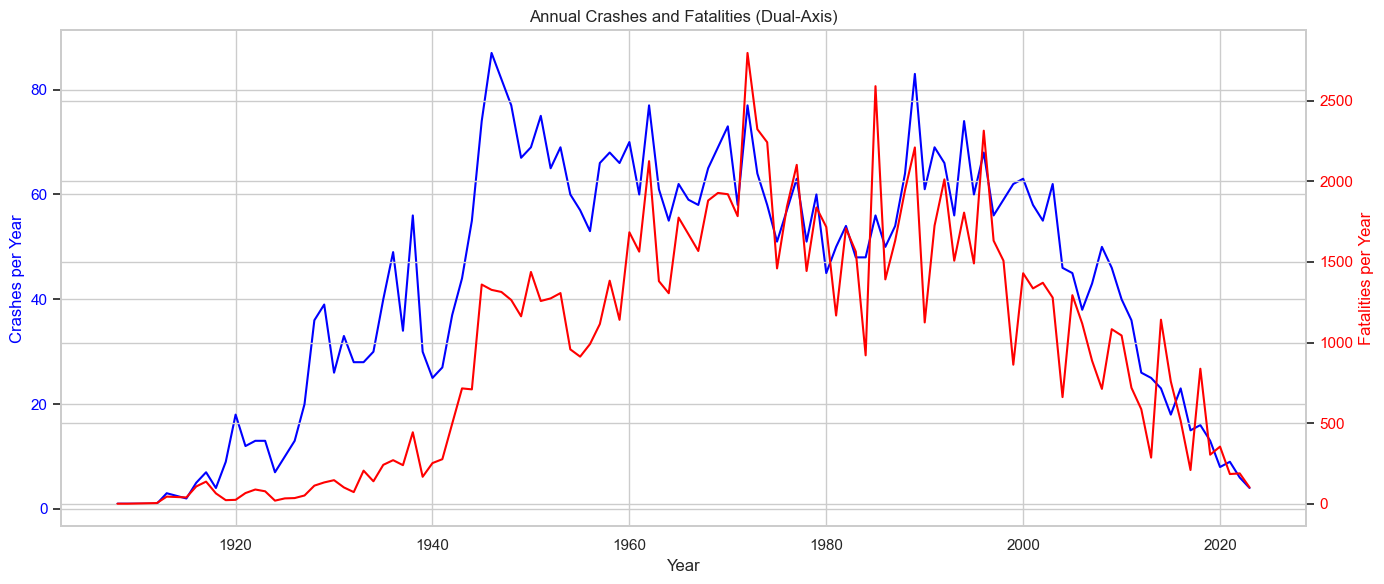

In [49]:
# Yearly aggregation
crashes_per_year = df.groupby('year').size()
fatalities_per_year = df.groupby('year')['fatalities'].sum()

# Dual-axis line plot
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

ax1.plot(crashes_per_year.index, crashes_per_year.values, label='Crashes', color='blue')
ax2.plot(fatalities_per_year.index, fatalities_per_year.values, label='Fatalities', color='red')

ax1.set_xlabel('Year')
ax1.set_ylabel('Crashes per Year', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.set_ylabel('Fatalities per Year', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Annual Crashes and Fatalities (Dual-Axis)')
fig.tight_layout()
plt.show()